# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a Spark session
spark = SparkSession\
        .builder\
        .appName('Sparkify')\
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load dataset
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Count the size and the missing values of the dataframe
for column in df.columns:
    print(column, 'missing values total:', df.filter(F.isnull(df[column])).count())

artist missing values total: 58392
auth missing values total: 0
firstName missing values total: 8346
gender missing values total: 8346
itemInSession missing values total: 0
lastName missing values total: 8346
length missing values total: 58392
level missing values total: 0
location missing values total: 8346
method missing values total: 0
page missing values total: 0
registration missing values total: 8346
sessionId missing values total: 0
song missing values total: 58392
status missing values total: 0
ts missing values total: 0
userAgent missing values total: 8346
userId missing values total: 0


> Each data point is a different page event, which may or may not have all the columns filled, so several columns with missing values, such as `artist`, could be ignored. The column that could not be tolerated with missing values is `userId` column, since it is the data point the new dataframe would be grouped by for the machine learning classification.

> Another column that we might not want to have any missing value would be the `sessionId`, since it is the primary data point for the `df` dataframe itself.

In [5]:
# Remove missing values from the userId and sessionId column
print('Number of data points before dropping missing values:', df.count())
df_clean = df.dropna(how='any', subset=['userId', 'sessionId'])
print('Number of data points after dropping missing values:', df_clean.count())

Number of data points before dropping missing values: 286500
Number of data points after dropping missing values: 286500


> It appears that there is no missing value in both columns. However, from the Udacity classroom, it was showed that the missing values might be in the format of an empty string `""`.

In [7]:
# Showing distinct userId
df_clean.select('userId').dropDuplicates().orderBy('userId').show(10)
print('userId empty string values:', df_clean.filter(df_clean.userId == '').count())

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows

userId empty string values: 8346


In [8]:
# Showing distinct sessionId
df_clean.select('sessionId').dropDuplicates().orderBy('sessionId').show(10)
print('sessionId empty string values:', df_clean.filter(df_clean.sessionId == '').count())

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows

sessionId empty string values: 0


> Only `userId` has empty string as values. Thus, remove them.

In [6]:
# Remove userId with empty string
df_clean = df_clean.filter(df_clean.userId != '')
print('userId empty string values:', df_clean.filter(df_clean.userId == '').count())
print('Data points without missing values:', df_clean.count())

userId empty string values: 0
Data points without missing values: 278154


In [7]:
# Change timestamp and registration format to DateType
df_clean = df_clean.withColumn('ts', F.from_unixtime(F.col('ts') / 1000))
df_clean = df_clean.withColumn('registration', F.from_unixtime(F.col('registration') / 1000))

In [9]:
# Save clean dataframe
df_clean.write.json(path='spark-warehouse/mini_sparkify_clean_event_data.json', mode='overwrite')

In [3]:
# Load clean dataframe
df_clean = spark.read.json('spark-warehouse/mini_sparkify_clean_event_data.json')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# Exploring the dataframe
df_clean.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|                 ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|2018-10-01 00:01:57|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

> Since the Sparkify data are basically web events and we need to predict users who are going to churn, we need to transform the data into the ones that are based on `userId` as the primary (each data points are going to be filled with columns/features of an individual user). I'm going to do that under the Feature Engineering section. Let's explore the data deeper in this one.

In [12]:
# Exploring all possible page of an event
df_clean.groupBy('page').count().orderBy('page').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|               About|   495|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|              Cancel|    52|
|Cancellation Conf...|    52|
|           Downgrade|  2055|
|               Error|   252|
|                Help|  1454|
|                Home| 10082|
|              Logout|  3226|
|            NextSong|228108|
|         Roll Advert|  3933|
|       Save Settings|   310|
|            Settings|  1514|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|         Thumbs Down|  2546|
|           Thumbs Up| 12551|
|             Upgrade|   499|
+--------------------+------+



In [9]:
# Create churn column to indicate whether a user is churned
ischurn = F.udf(lambda page: 1 if page == 'Cancellation Confirmation' else 0, IntegerType())
df_user_churn = df_clean.withColumn('churn', ischurn(df_clean.page)).groupBy('userId').agg(F.sum('churn').alias('isChurn'))
df_clean = df_clean.join(df_user_churn, ['userId'])

In [11]:
# Save df_clean with churn column
df_clean.write.json(path='spark-warehouse/mini_sparkify_event_data_churn.json', mode='overwrite')

In [7]:
# Load df_clean with churn column
df_clean = spark.read.json('spark-warehouse/mini_sparkify_event_data_churn.json')

In [37]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- isChurn: long (nullable = true)



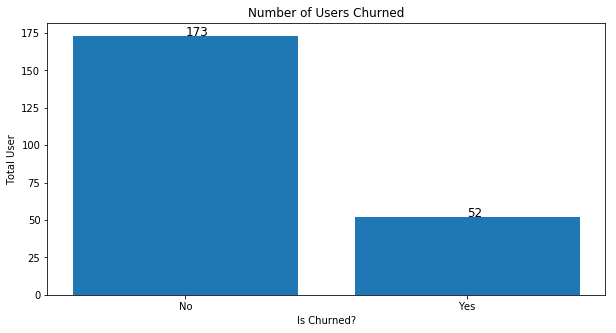

In [14]:
# Plot bar diagram for number of churned users
churn_num = df_clean.select('userId', 'isChurn').distinct().groupBy('isChurn').count().toPandas()
churn_num['isChurn'] = ['No', 'Yes']

X, y = churn_num['isChurn'], churn_num['count']
fig, ax = plt.subplots(figsize = (10,5))
ax.bar(X, y)

for i, val in enumerate(y):
    ax.text(X[i], val, str(val), fontdict=dict(fontsize=12))
plt.title('Number of Users Churned')
plt.xlabel('Is Churned?')
plt.ylabel('Total User')
plt.show();

### Exploring Data: Churned vs. Not Churned

In [15]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- isChurn: long (nullable = true)



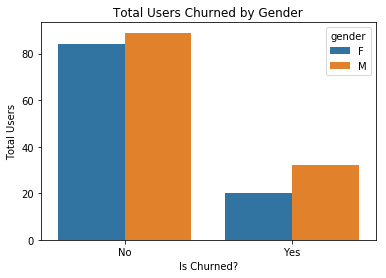

In [55]:
# Exploring gender feature
df_user_gender_churn = df_clean.groupBy(['userId', 'gender']).agg(F.max(F.col('isChurn')).alias('isChurn'))
pd_gender_churn = df_user_gender_churn.groupBy(['gender', 'isChurn']).count().toPandas()
pd_gender_churn['isChurn'] = pd_gender_churn['isChurn'].apply(lambda churn_val: 'Yes' if churn_val == 1 else 'No')

ax = sns.barplot(x='isChurn', y='count', hue='gender', data=pd_gender_churn)

plt.title('Total Users Churned by Gender')
plt.ylabel('Total Users')
plt.xlabel('Is Churned?')
plt.show()

> It appears that the female to male ratio is significantly different between the users who are churned and not. This suggests that it might be a useful feature to include in the model training.

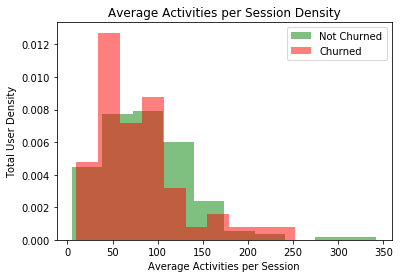

In [22]:
# Exploring item in session
df_item_session = df_clean.groupBy(['userId', 'sessionId']).agg(F.max(F.col('itemInSession')).alias('itemsTotal'))
df_item_session = df_item_session.groupBy('userId').agg(F.avg(F.col('itemsTotal')).alias('itemsPerSession'))
pd_item_session = df_item_session.join(df_user_churn, ['userId']).toPandas()

# Visualize the items per session average 
item_session_nochurned = pd_item_session[pd_item_session.isChurn == 0]['itemsPerSession']
item_session_churned = pd_item_session[pd_item_session.isChurn == 1]['itemsPerSession']
kwargs = dict(alpha=0.5)

plt.hist(item_session_nochurned, **kwargs, color='g', label='Not Churned', density=True)
plt.hist(item_session_churned, **kwargs, color='r', label='Churned', density=True)

plt.title('Average Activities per Session Density')
plt.xlabel('Average Activities per Session')
plt.ylabel('Total User Density')

plt.legend()
plt.show()

> The distribution of average number of items per session of the users who are not churned are bimodal while those who churned looks rightly skewed. This suggests that it might be a useful feature.

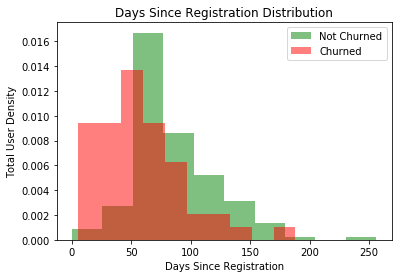

In [62]:
# Exploring registration
# distribution comparison of number of days after registration between the two groups
df_days_since_reg = df_clean.withColumn('ts', F.date_trunc('day', F.col('ts')))\
                        .withColumn('registration', F.date_trunc('day', F.col('registration')))\
                        .groupBy(['userId', 'registration']).agg(F.max(F.col('ts')).alias('maxTs'))\
                        .select('userId', ((F.col('maxTs').cast('long') - F.col('registration')\
                                            .cast('long')) / (60*60*24)).alias('daysSinceReg'))\
                        .join(df_user_churn, ['userId'])
pd_days_since_reg = df_days_since_reg.toPandas()

# Visualize the items per session average 
days_since_reg_nochurned = pd_days_since_reg[pd_days_since_reg.isChurn == 0]['daysSinceReg']
days_since_reg_churned = pd_days_since_reg[pd_days_since_reg.isChurn == 1]['daysSinceReg']
kwargs = dict(alpha=0.5)

plt.hist(days_since_reg_nochurned, **kwargs, color='g', label='Not Churned', density=True)
plt.hist(days_since_reg_churned, **kwargs, color='r', label='Churned', density=True)

plt.title('Days Since Registration Distribution')
plt.xlabel('Days Since Registration')
plt.ylabel('Total User Density')

plt.legend()
plt.show()

> Those who churn tend to do it in the first 50 days since their registrations. Thus, this features might also be useful to be included in training.

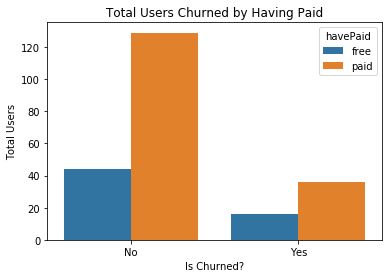

In [40]:
# Exploring status
df_user_level_churn = df_clean.groupBy('userId')\
                        .agg(F.max(F.col('level')).alias('havePaid'), F.max(F.col('isChurn')).alias('isChurn'))\
                        .groupBy(['havePaid', 'isChurn']).count()
pd_level_churn = df_user_level_churn.toPandas()
pd_level_churn['isChurn'] = pd_level_churn['isChurn'].apply(lambda churn_val: 'Yes' if churn_val == 1 else 'No')

ax = sns.barplot(x='isChurn', y='count', hue='havePaid', data=pd_level_churn)

plt.title('Total Users Churned by Having Paid')
plt.ylabel('Total Users')
plt.xlabel('Is Churned?')
plt.show()

> The ratio of free to paid between the two groups seems to be significantly different: the number of people who pay tends to be larger in the group who do not churn. Thus, this feature would be included in training.

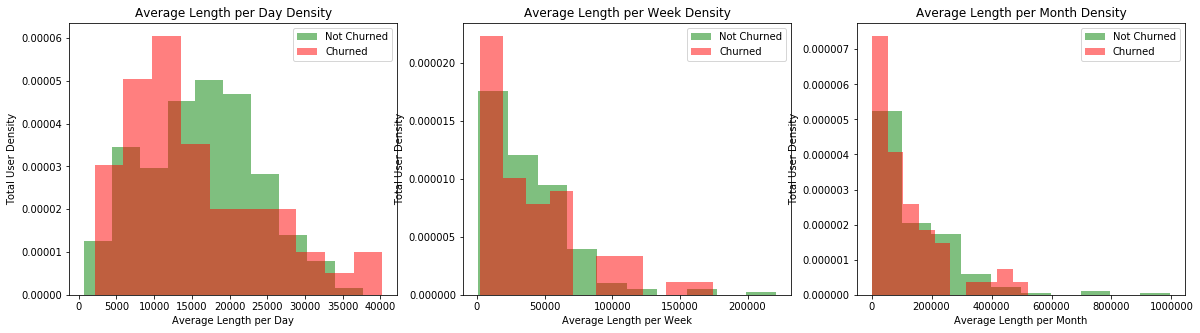

In [10]:
# Exploring length of songs heard by time interval: day, week, month
df_length_per_day = df_clean.withColumn('ts', F.date_trunc('day', F.col('ts'))).groupBy(['userId', 'ts'])\
                            .agg(F.sum(F.col('length')).alias('lengthPerDay')).groupBy('userId')\
                            .agg(F.avg(F.col('lengthPerDay')).alias('avgLengthPerDay'))\
                            .join(df_user_churn, ['userId'])
df_length_per_week = df_clean.withColumn('ts', F.date_trunc('week', F.col('ts'))).groupBy(['userId', 'ts'])\
                            .agg(F.sum(F.col('length')).alias('lengthPerWeek')).groupBy('userId')\
                            .agg(F.avg(F.col('lengthPerWeek')).alias('avgLengthPerWeek'))\
                            .join(df_user_churn, ['userId'])
df_length_per_month = df_clean.withColumn('ts', F.date_trunc('month', F.col('ts'))).groupBy(['userId', 'ts'])\
                            .agg(F.sum(F.col('length')).alias('lengthPerMonth')).groupBy('userId')\
                            .agg(F.avg(F.col('lengthPerMonth')).alias('avgLengthPerMonth'))\
                            .join(df_user_churn, ['userId'])

pd_length_per_day = df_length_per_day.toPandas()
pd_length_per_week = df_length_per_week.toPandas()
pd_length_per_month = df_length_per_month.toPandas()

# Visualize the items per session average 
length_dfs = [pd_length_per_day, pd_length_per_week, pd_length_per_month]
length_interval = ['avgLengthPerDay', 'avgLengthPerWeek', 'avgLengthPerMonth']
interval_names = ['Day', 'Week', 'Month']


kwargs = dict(alpha=0.5)

fig = plt.figure(figsize=(20, 5))
for i, length_df in enumerate(length_dfs):
    nochurned = length_df[length_df.isChurn == 0][length_interval[i]]
    churned = length_df[length_df.isChurn == 1][length_interval[i]]
    
    fig.add_subplot(1, 3, i + 1)

    plt.hist(nochurned, **kwargs, color='g', label='Not Churned', density=True)
    plt.hist(churned, **kwargs, color='r', label='Churned', density=True)

    plt.title('Average Length per ' + interval_names[i] + ' Density')
    plt.xlabel('Average Length per ' + interval_names[i])
    plt.ylabel('Total User Density')

    plt.legend()
plt.show();

> These features might also prove useful to the training process, since their distributions seems different in central values or in the prevalence of certain values.

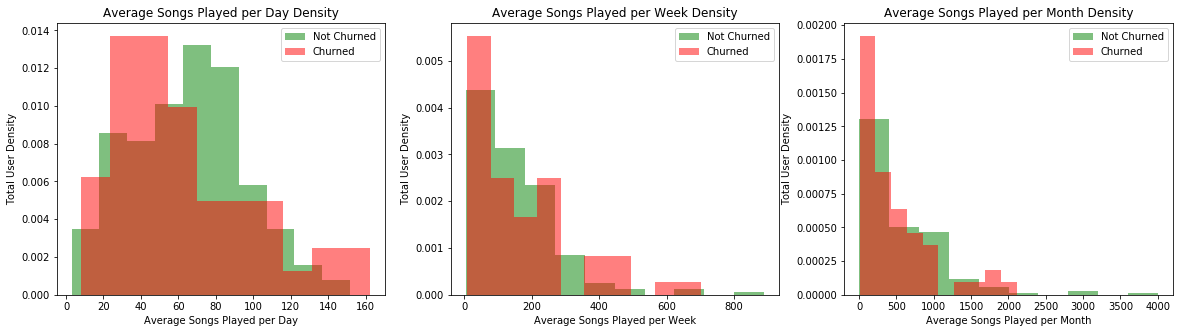

In [11]:
# Exploring number of songs by time interval: day, week, month
df_songs_per_day = df_clean.filter('page == "NextSong"').withColumn('ts', F.date_trunc('day', F.col('ts')))\
                            .groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('songsPerDay'))\
                            .groupBy(['userId']).agg(F.avg(F.col('songsPerDay')).alias('avgSongsPerDay'))\
                            .join(df_user_churn, ['userId'])
df_songs_per_week = df_clean.filter('page == "NextSong"').withColumn('ts', F.date_trunc('week', F.col('ts')))\
                            .groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('songsPerWeek'))\
                            .groupBy(['userId']).agg(F.avg(F.col('songsPerWeek')).alias('avgSongsPerWeek'))\
                            .join(df_user_churn, ['userId'])
df_songs_per_month = df_clean.filter('page == "NextSong"').withColumn('ts', F.date_trunc('month', F.col('ts')))\
                            .groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('songsPerMonth'))\
                            .groupBy(['userId']).agg(F.avg(F.col('songsPerMonth')).alias('avgSongsPerMonth'))\
                            .join(df_user_churn, ['userId'])

pd_songs_per_day = df_songs_per_day.toPandas()
pd_songs_per_week = df_songs_per_week.toPandas()
pd_songs_per_month = df_songs_per_month.toPandas()

# Visualize the items per session average 
songs_dfs = [pd_songs_per_day, pd_songs_per_week, pd_songs_per_month]
songs_interval = ['avgSongsPerDay', 'avgSongsPerWeek', 'avgSongsPerMonth']
interval_names = ['Day', 'Week', 'Month']


kwargs = dict(alpha=0.5)

fig = plt.figure(figsize=(20, 5))
for i, song_df in enumerate(songs_dfs):
    nochurned = song_df[song_df.isChurn == 0][songs_interval[i]]
    churned = song_df[song_df.isChurn == 1][songs_interval[i]]
    
    fig.add_subplot(1, 3, i + 1)

    plt.hist(nochurned, **kwargs, color='g', label='Not Churned', density=True)
    plt.hist(churned, **kwargs, color='r', label='Churned', density=True)

    plt.title('Average Songs Played per ' + interval_names[i] + ' Density')
    plt.xlabel('Average Songs Played per ' + interval_names[i])
    plt.ylabel('Total User Density')

    plt.legend()
plt.show();

> As with the average length of songs played within an interval above, average number of songs might also be good features, given the difference in density or central value between group distributions.

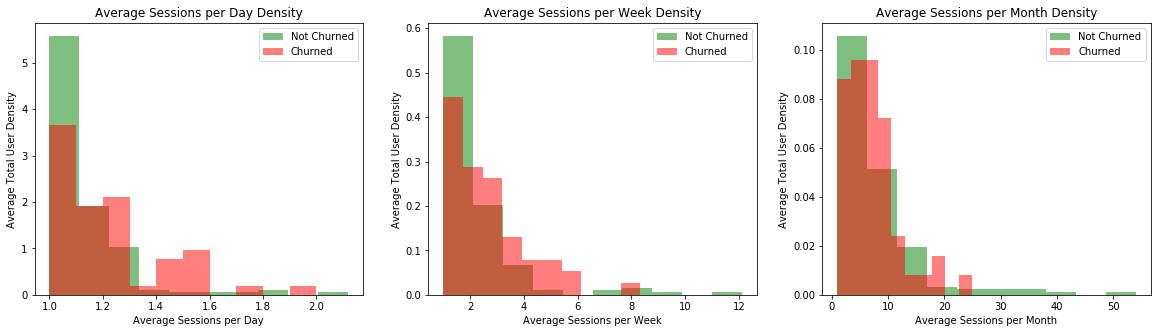

In [12]:
# Exploring number of sessions by time interval: day, week, month
df_sessions_per_day = df_clean.withColumn('ts', F.date_trunc('day', F.col('ts'))).groupBy(['userId', 'ts'])\
                        .agg(F.countDistinct(F.col('sessionId')).alias('sessionsPerDay')).groupBy('userId')\
                        .agg(F.avg(F.col('sessionsPerDay')).alias('avgSessionsPerDay'))\
                        .join(df_user_churn, ['userId'])
df_sessions_per_week = df_clean.withColumn('ts', F.date_trunc('week', F.col('ts'))).groupBy(['userId', 'ts'])\
                        .agg(F.countDistinct(F.col('sessionId')).alias('sessionsPerWeek')).groupBy('userId')\
                        .agg(F.avg(F.col('sessionsPerWeek')).alias('avgSessionsPerWeek'))\
                        .join(df_user_churn, ['userId'])
df_sessions_per_month = df_clean.withColumn('ts', F.date_trunc('month', F.col('ts'))).groupBy(['userId', 'ts'])\
                        .agg(F.countDistinct(F.col('sessionId')).alias('sessionsPerMonth')).groupBy('userId')\
                        .agg(F.avg(F.col('sessionsPerMonth')).alias('avgSessionsPerMonth'))\
                        .join(df_user_churn, ['userId'])

pd_sessions_per_day = df_sessions_per_day.toPandas()
pd_sessions_per_week = df_sessions_per_week.toPandas()
pd_sessions_per_month = df_sessions_per_month.toPandas()

# Visualize the items per session average 
sessions_dfs = [pd_sessions_per_day, pd_sessions_per_week, pd_sessions_per_month]
sessions_interval = ['avgSessionsPerDay', 'avgSessionsPerWeek', 'avgSessionsPerMonth']
interval_names = ['Day', 'Week', 'Month']


kwargs = dict(alpha=0.5)

fig = plt.figure(figsize=(20, 5))
for i, sessions_df in enumerate(sessions_dfs):
    nochurned = sessions_df[sessions_df.isChurn == 0][sessions_interval[i]]
    churned = sessions_df[sessions_df.isChurn == 1][sessions_interval[i]]
    
    fig.add_subplot(1, 3, i + 1)

    plt.hist(nochurned, **kwargs, color='g', label='Not Churned', density=True)
    plt.hist(churned, **kwargs, color='r', label='Churned', density=True)

    plt.title('Average Sessions per ' + interval_names[i] + ' Density')
    plt.xlabel('Average Sessions per ' + interval_names[i])
    plt.ylabel('Average Total User Density')

    plt.legend()
plt.show();

> The difference between group distributions also suggests to include these features to the training. It's also interesting to note that the distribution of people who churn tend to have thicker upper-tail.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [41]:
# Create new dataframe to train the model
df_transformed = df_user_churn

### Extract features: sum of each page visits

In [42]:
pd_page_names = df_clean.select('page').distinct().toPandas()
page_names = pd_page_names.page.tolist()
page_names.remove('Cancellation Confirmation') # will be for the label
page_names.remove('NextSong') # will be engineered with the average songs played by time interval

for page in page_names:
    df_page = df_clean.groupBy(['userId', 'page']).agg(F.count(F.col('page'))\
                    .alias('sumPage' + page.replace(' ', ''))).filter('page == "' + page + '"').drop('page')
    df_transformed = df_transformed.join(df_page, ['userId'], 'left').fillna(0)

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0)

### Extract Features: gender

In [43]:
df_gender = df_clean.select('userId', 'gender').distinct()
isGender = F.udf(lambda gender: 0 if gender == 'M' else 1, IntegerType())
df_gender = df_gender.withColumn('gender', isGender(F.col('gender')))
df_transformed = df_transformed.join(df_gender, ['userId'])

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0, gender=1)

### Extract Feature: has a user paid for upgrade?

In [45]:
df_havePaid = df_clean.groupBy('userId').agg(F.max(F.col('level')).alias('havePaid'))
havePaid = F.udf(lambda x: 0 if x == 'free' else 1, IntegerType())
df_havePaid = df_havePaid.withColumn('havePaid', havePaid(F.col('havePaid')))
df_transformed = df_transformed.join(df_havePaid, ['userId'])

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0, gender=1, havePaid=0)

### Extract Feature: average item per session

In [46]:
# Extract featurs: avgItemPerSession
df_avgItemPerSession = df_clean.groupBy(['userId', 'sessionId'])\
                            .agg(F.max(F.col('itemInSession')).alias('itemsTotal'))\
                            .groupBy('userId').agg(F.avg(F.col('itemsTotal')).alias('avgItemsPerSession'))
df_transformed = df_transformed.join(df_avgItemPerSession, ['userId'])

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0, gender=1, havePaid=0, avgItemsPerSession=54.42857142857143)

### Extract Featurs: average length of songs heard per day, week, & month

In [48]:
df_length_per_day = df_clean.withColumn('ts', F.date_trunc('day', F.col('ts'))).groupBy(['userId', 'ts'])\
                            .agg(F.sum(F.col('length')).alias('lengthPerDay')).groupBy('userId')\
                            .agg(F.avg(F.col('lengthPerDay')).alias('avgLengthPerDay'))
df_length_per_week = df_clean.withColumn('ts', F.date_trunc('week', F.col('ts'))).groupBy(['userId', 'ts'])\
                            .agg(F.sum(F.col('length')).alias('lengthPerWeek')).groupBy('userId')\
                            .agg(F.avg(F.col('lengthPerWeek')).alias('avgLengthPerWeek'))
df_length_per_month = df_clean.withColumn('ts', F.date_trunc('month', F.col('ts'))).groupBy(['userId', 'ts'])\
                            .agg(F.sum(F.col('length')).alias('lengthPerMonth')).groupBy('userId')\
                            .agg(F.avg(F.col('lengthPerMonth')).alias('avgLengthPerMonth'))

df_transformed = df_transformed.join(df_length_per_day, ['userId'])\
                            .join(df_length_per_week, ['userId'])\
                            .join(df_length_per_month, ['userId'])

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0, gender=1, havePaid=0, avgItemsPerSession=54.42857142857143, avgLengthPerDay=9562.985335714286, avgLengthPerWeek=16735.224337499996, avgLengthPerMonth=33470.448675)

### Extract Features: average number of songs played by day, week, & month

In [49]:
# Extract features: number of songs by time interval
df_songs_per_day = df_clean.filter('page == "NextSong"').withColumn('ts', F.date_trunc('day', F.col('ts')))\
                            .groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('songsPerDay'))\
                            .groupBy(['userId']).agg(F.avg(F.col('songsPerDay')).alias('avgSongsPerDay'))
df_songs_per_week = df_clean.filter('page == "NextSong"').withColumn('ts', F.date_trunc('week', F.col('ts')))\
                            .groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('songsPerWeek'))\
                            .groupBy(['userId']).agg(F.avg(F.col('songsPerWeek')).alias('avgSongsPerWeek'))
df_songs_per_month = df_clean.filter('page == "NextSong"').withColumn('ts', F.date_trunc('month', F.col('ts')))\
                            .groupBy(['userId', 'ts']).agg(F.count(F.col('page')).alias('songsPerMonth'))\
                            .groupBy(['userId']).agg(F.avg(F.col('songsPerMonth')).alias('avgSongsPerMonth'))

df_transformed = df_transformed.join(df_songs_per_day, ['userId'])\
                            .join(df_songs_per_week, ['userId'])\
                            .join(df_songs_per_month, ['userId'])

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0, gender=1, havePaid=0, avgItemsPerSession=54.42857142857143, avgLengthPerDay=9562.985335714286, avgLengthPerWeek=16735.224337499996, avgLengthPerMonth=33470.448675, avgSongsPerDay=39.285714285714285, avgSongsPerWeek=68.75, avgSongsPerMonth=137.5)

### Extract Features: average number of sessions per day, week, & month

In [50]:
# Extract features: number of sessions by time interval
df_sessions_per_day = df_clean.withColumn('ts', F.date_trunc('day', F.col('ts'))).groupBy(['userId', 'ts'])\
                        .agg(F.countDistinct(F.col('sessionId')).alias('sessionsPerDay')).groupBy('userId')\
                        .agg(F.avg(F.col('sessionsPerDay')).alias('avgSessionsPerDay'))
df_sessions_per_week = df_clean.withColumn('ts', F.date_trunc('week', F.col('ts'))).groupBy(['userId', 'ts'])\
                        .agg(F.countDistinct(F.col('sessionId')).alias('sessionsPerWeek')).groupBy('userId')\
                        .agg(F.avg(F.col('sessionsPerWeek')).alias('avgSessionsPerWeek'))
df_sessions_per_month = df_clean.withColumn('ts', F.date_trunc('month', F.col('ts'))).groupBy(['userId', 'ts'])\
                        .agg(F.countDistinct(F.col('sessionId')).alias('sessionsPerMonth')).groupBy('userId')\
                        .agg(F.avg(F.col('sessionsPerMonth')).alias('avgSessionsPerMonth'))

df_transformed = df_transformed.join(df_sessions_per_day, ['userId'])\
                            .join(df_sessions_per_week, ['userId'])\
                            .join(df_sessions_per_month, ['userId'])

df_transformed.head()

Row(userId='100010', isChurn=0, sumPageCancel=0, sumPageSubmitDowngrade=0, sumPageThumbsDown=5, sumPageHome=11, sumPageDowngrade=0, sumPageRollAdvert=52, sumPageLogout=5, sumPageSaveSettings=0, sumPageAbout=1, sumPageSettings=0, sumPageAddtoPlaylist=7, sumPageAddFriend=4, sumPageThumbsUp=17, sumPageHelp=2, sumPageUpgrade=2, sumPageError=0, sumPageSubmitUpgrade=0, gender=1, havePaid=0, avgItemsPerSession=54.42857142857143, avgLengthPerDay=9562.985335714286, avgLengthPerWeek=16735.224337499996, avgLengthPerMonth=33470.448675, avgSongsPerDay=39.285714285714285, avgSongsPerWeek=68.75, avgSongsPerMonth=137.5, avgSessionsPerDay=1.0, avgSessionsPerWeek=1.75, avgSessionsPerMonth=3.5)

### Note regarding location and user-agent column

In [51]:
print('Number of features already extracted:', len(df_transformed.columns))
print('Number of unique user-agent:', df_clean.select('userAgent').distinct().count())
print('Number of unique state:', df.withColumn('stateCode', df.location.substr(-2, 2)).select('stateCode').distinct().count())

Number of features already extracted: 31
Number of unique user-agent: 56
Number of unique state: 40


> If I add each user-agent and state location as one-hot encoding features, the number of features would be more than half the number of data point (225). Thus, these features are currently neglected and reserved for a bigger dataset.

In [53]:
df_transformed.count()

225

In [54]:
# Check if there's any NaN
for column in df_transformed.columns:
    print(column, 'missing values total:', df_transformed.filter(F.isnull(df_transformed[column])).count())

userId missing values total: 0
isChurn missing values total: 0
sumPageCancel missing values total: 0
sumPageSubmitDowngrade missing values total: 0
sumPageThumbsDown missing values total: 0
sumPageHome missing values total: 0
sumPageDowngrade missing values total: 0
sumPageRollAdvert missing values total: 0
sumPageLogout missing values total: 0
sumPageSaveSettings missing values total: 0
sumPageAbout missing values total: 0
sumPageSettings missing values total: 0
sumPageAddtoPlaylist missing values total: 0
sumPageAddFriend missing values total: 0
sumPageThumbsUp missing values total: 0
sumPageHelp missing values total: 0
sumPageUpgrade missing values total: 0
sumPageError missing values total: 0
sumPageSubmitUpgrade missing values total: 0
gender missing values total: 0
havePaid missing values total: 0
avgItemsPerSession missing values total: 0
avgLengthPerDay missing values total: 0
avgLengthPerWeek missing values total: 0
avgLengthPerMonth missing values total: 0
avgSongsPerDay miss

In [52]:
# Save transformed dataframe
df_transformed.write.json(path='spark-warehouse/mini_sparkify_transformed_data.json', mode='overwrite')

In [4]:
# Load dataset
df_transformed = spark.read.json('spark-warehouse/mini_sparkify_transformed_data.json')

df_transformed.persist()

DataFrame[avgItemsPerSession: double, avgLengthPerDay: double, avgLengthPerMonth: double, avgLengthPerWeek: double, avgSessionsPerDay: double, avgSessionsPerMonth: double, avgSessionsPerWeek: double, avgSongsPerDay: double, avgSongsPerMonth: double, avgSongsPerWeek: double, gender: bigint, havePaid: bigint, isChurn: bigint, sumPageAbout: bigint, sumPageAddFriend: bigint, sumPageAddtoPlaylist: bigint, sumPageCancel: bigint, sumPageDowngrade: bigint, sumPageError: bigint, sumPageHelp: bigint, sumPageHome: bigint, sumPageLogout: bigint, sumPageRollAdvert: bigint, sumPageSaveSettings: bigint, sumPageSettings: bigint, sumPageSubmitDowngrade: bigint, sumPageSubmitUpgrade: bigint, sumPageThumbsDown: bigint, sumPageThumbsUp: bigint, sumPageUpgrade: bigint, userId: string]

In [5]:
df_transformed.count()

225

In [13]:
df_transformed.printSchema()

root
 |-- avgItemsPerSession: double (nullable = true)
 |-- avgLengthPerDay: double (nullable = true)
 |-- avgLengthPerMonth: double (nullable = true)
 |-- avgLengthPerWeek: double (nullable = true)
 |-- avgSessionsPerDay: double (nullable = true)
 |-- avgSessionsPerMonth: double (nullable = true)
 |-- avgSessionsPerWeek: double (nullable = true)
 |-- avgSongsPerDay: double (nullable = true)
 |-- avgSongsPerMonth: double (nullable = true)
 |-- avgSongsPerWeek: double (nullable = true)
 |-- gender: long (nullable = true)
 |-- havePaid: long (nullable = true)
 |-- isChurn: long (nullable = true)
 |-- sumPageAbout: long (nullable = true)
 |-- sumPageAddFriend: long (nullable = true)
 |-- sumPageAddtoPlaylist: long (nullable = true)
 |-- sumPageCancel: long (nullable = true)
 |-- sumPageDowngrade: long (nullable = true)
 |-- sumPageError: long (nullable = true)
 |-- sumPageHelp: long (nullable = true)
 |-- sumPageHome: long (nullable = true)
 |-- sumPageLogout: long (nullable = true)
 |-- 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Assembling Features into a Vector

In [27]:
# Assemble features in a vector
feature_names = df_transformed.columns
feature_names.remove('isChurn')
feature_names.remove('userId')
feature_names

['avgItemsPerSession',
 'avgLengthPerDay',
 'avgLengthPerMonth',
 'avgLengthPerWeek',
 'avgSessionsPerDay',
 'avgSessionsPerMonth',
 'avgSessionsPerWeek',
 'avgSongsPerDay',
 'avgSongsPerMonth',
 'avgSongsPerWeek',
 'gender',
 'havePaid',
 'sumPageAbout',
 'sumPageAddFriend',
 'sumPageAddtoPlaylist',
 'sumPageCancel',
 'sumPageDowngrade',
 'sumPageError',
 'sumPageHelp',
 'sumPageHome',
 'sumPageLogout',
 'sumPageRollAdvert',
 'sumPageSaveSettings',
 'sumPageSettings',
 'sumPageSubmitDowngrade',
 'sumPageSubmitUpgrade',
 'sumPageThumbsDown',
 'sumPageThumbsUp',
 'sumPageUpgrade']

In [28]:
# Assemble features in a vector
assembler = VectorAssembler(inputCols=feature_names, outputCol='featuresAssembled')
df_assembled = assembler.transform(df_transformed)
df_assembled.head()

Row(avgItemsPerSession=60.666666666666664, avgLengthPerDay=12183.17838368421, avgLengthPerMonth=115740.19464500001, avgLengthPerWeek=25720.043254444445, avgSessionsPerDay=1.263157894736842, avgSessionsPerMonth=10.5, avgSessionsPerWeek=2.3333333333333335, avgSongsPerDay=49.578947368421055, avgSongsPerMonth=471.0, avgSongsPerWeek=104.66666666666667, gender=1, havePaid=1, isChurn=0, sumPageAbout=0, sumPageAddFriend=19, sumPageAddtoPlaylist=23, sumPageCancel=0, sumPageDowngrade=10, sumPageError=2, sumPageHelp=6, sumPageHome=66, sumPageLogout=19, sumPageRollAdvert=86, sumPageSaveSettings=2, sumPageSettings=11, sumPageSubmitDowngrade=2, sumPageSubmitUpgrade=3, sumPageThumbsDown=11, sumPageThumbsUp=35, sumPageUpgrade=8, userId='100004', featuresAssembled=DenseVector([60.6667, 12183.1784, 115740.1946, 25720.0433, 1.2632, 10.5, 2.3333, 49.5789, 471.0, 104.6667, 1.0, 1.0, 0.0, 19.0, 23.0, 0.0, 10.0, 2.0, 6.0, 66.0, 19.0, 86.0, 2.0, 11.0, 2.0, 3.0, 11.0, 35.0, 8.0]))

### Scaling Features

In [29]:
# Rescale the features
scaler = Normalizer(inputCol='featuresAssembled', outputCol='features')
df_scaled = scaler.transform(df_assembled)
df_scaled.head()

Row(avgItemsPerSession=60.666666666666664, avgLengthPerDay=12183.17838368421, avgLengthPerMonth=115740.19464500001, avgLengthPerWeek=25720.043254444445, avgSessionsPerDay=1.263157894736842, avgSessionsPerMonth=10.5, avgSessionsPerWeek=2.3333333333333335, avgSongsPerDay=49.578947368421055, avgSongsPerMonth=471.0, avgSongsPerWeek=104.66666666666667, gender=1, havePaid=1, isChurn=0, sumPageAbout=0, sumPageAddFriend=19, sumPageAddtoPlaylist=23, sumPageCancel=0, sumPageDowngrade=10, sumPageError=2, sumPageHelp=6, sumPageHome=66, sumPageLogout=19, sumPageRollAdvert=86, sumPageSaveSettings=2, sumPageSettings=11, sumPageSubmitDowngrade=2, sumPageSubmitUpgrade=3, sumPageThumbsDown=11, sumPageThumbsUp=35, sumPageUpgrade=8, userId='100004', featuresAssembled=DenseVector([60.6667, 12183.1784, 115740.1946, 25720.0433, 1.2632, 10.5, 2.3333, 49.5789, 471.0, 104.6667, 1.0, 1.0, 0.0, 19.0, 23.0, 0.0, 10.0, 2.0, 6.0, 66.0, 19.0, 86.0, 2.0, 11.0, 2.0, 3.0, 11.0, 35.0, 8.0]), features=DenseVector([0.0005,

### Aliasing Label

In [30]:
df_ml = df_scaled.select(F.col('isChurn').alias('label'), F.col('features'))
df_ml.head()

Row(label=0, features=DenseVector([0.0005, 0.1022, 0.9711, 0.2158, 0.0, 0.0001, 0.0, 0.0004, 0.004, 0.0009, 0.0, 0.0, 0.0, 0.0002, 0.0002, 0.0, 0.0001, 0.0, 0.0001, 0.0006, 0.0002, 0.0007, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0003, 0.0001]))

In [37]:
# Save df_ml
df_ml.write.json(path='spark-warehouse/mini_sparkify_ml_data.json', mode='overwrite')

In [6]:
df_ml = spark.read.json('spark-warehouse/mini_sparkify_ml_data.json')

DataFrame[features: struct<indices:array<bigint>,size:bigint,type:bigint,values:array<double>>, label: bigint]

In [36]:
df_ml.head()

Row(label=0, features=DenseVector([0.0005, 0.1022, 0.9711, 0.2158, 0.0, 0.0001, 0.0, 0.0004, 0.004, 0.0009, 0.0, 0.0, 0.0, 0.0002, 0.0002, 0.0, 0.0001, 0.0, 0.0001, 0.0006, 0.0002, 0.0007, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0003, 0.0001]))

In [31]:
df_ml.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)



### Train and Test Data Split

In [32]:
# Split train and test data
train, test = df_ml.randomSplit([.8, .2], seed=42)

### Logistic Regression Evaluation

In [33]:
# Logistic Regression
lr = LogisticRegression()

lr_param_grid = ParamGridBuilder()\
                .addGrid(lr.regParam, [0.0, 0.1, 0.2])\
                .addGrid(lr.maxIter, [25, 50, 100])\
                .build()
lr_cross_val = CrossValidator(estimator=lr,
                              estimatorParamMaps=lr_param_grid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3)
lr_model = lr_cross_val.fit(train)

In [34]:
lr_model.avgMetrics

[0.9181782116564725,
 0.921785079393775,
 0.921785079393775,
 0.9095974856844422,
 0.908388859475816,
 0.908388859475816,
 0.9002231447883622,
 0.8985575398618877,
 0.8985575398618877]

In [35]:
# Predict on test dataset
lr_result = lr_model.transform(test)
acc = lr_result.filter(lr_result.label == lr_result.prediction).count() / lr_result.count()
print('Logistic Regression Accuracy:', acc)

Logistic Regression Accuracy: 0.9615384615384616


### Random Forest Evaluation

In [38]:
# Random Forest
rf = RandomForestClassifier()
rf_param_grid = ParamGridBuilder()\
                .addGrid(rf.numTrees, [10, 20, 30])\
                .addGrid(rf.maxDepth, [2, 5, 10])\
                .build()
rf_cross_val = CrossValidator(estimator=rf,
                              estimatorParamMaps=rf_param_grid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3)
rf_model = rf_cross_val.fit(train)

In [39]:
rf_model.avgMetrics

[1.0, 1.0, 1.0, 0.9855072463768115, 1.0, 1.0, 1.0, 1.0, 1.0]

In [40]:
# Predict on test dataset
rf_result = rf_model.transform(test)
acc = rf_result.filter(rf_result.label == rf_result.prediction).count() / rf_result.count()
print('Random Forest Accuracy:', acc)

Random Forest Accuracy: 1.0


### Gradient-boosted Tree Evaluation

In [41]:
# Gradient-boosted Tree
gbt = GBTClassifier()
gbt_param_grid = ParamGridBuilder()\
                .addGrid(gbt.maxIter, [10, 20, 30])\
                .addGrid(gbt.maxDepth, [2, 5, 10])\
                .build()
gbt_cross_val = CrossValidator(estimator=gbt,
                               estimatorParamMaps=gbt_param_grid,
                               evaluator=BinaryClassificationEvaluator(),
                               numFolds=3)
gbt_model = gbt_cross_val.fit(train)

In [42]:
gbt_model.avgMetrics

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [43]:
# Predict on test dataset
gbt_result = gbt_model.transform(test)
acc = gbt_result.filter(gbt_result.label == gbt_result.prediction).count() / gbt_result.count()
print('Gradient-boosted Tree Accuracy:', acc)

Gradient-boosted Tree Accuracy: 1.0


### Decision Tree Evaluation

In [44]:
# Decision Tree
dt = DecisionTreeClassifier()
dt_param_grid = ParamGridBuilder()\
                .addGrid(dt.impurity, ['gini', 'entropy'])\
                .addGrid(dt.maxDepth, [2, 5])\
                .build()
dt_cross_val = CrossValidator(estimator=dt,
                               estimatorParamMaps=dt_param_grid,
                               evaluator=BinaryClassificationEvaluator(),
                               numFolds=3)
dt_model = dt_cross_val.fit(train)

In [45]:
dt_model.avgMetrics

[1.0, 1.0, 1.0, 1.0]

In [46]:
# Predict on test dataset
dt_result = dt_model.transform(test)
acc = dt_result.filter(dt_result.label == dt_result.prediction).count() / dt_result.count()
print('Gradient-boosted Tree Accuracy:', acc)

Gradient-boosted Tree Accuracy: 1.0


### Naive Bayes Evaluation

In [53]:
# Naive Bayes
nb = NaiveBayes()
nb_param_grid = ParamGridBuilder()\
                .addGrid(nb.smoothing, [0.0, 0.5, 1.0])\
                .build()
nb_cross_val = CrossValidator(estimator=nb,
                              estimatorParamMaps=nb_param_grid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3)
nb_model = nb_cross_val.fit(train)

In [54]:
nb_model.avgMetrics

[0.40776921211703815, 0.4048949809819375, 0.4041442302311867]

In [55]:
# Predict on test dataset
nb_result = nb_model.transform(test)
acc = nb_result.filter(nb_result.label == nb_result.prediction).count() / nb_result.count()
print('Naive Bayes Accuracy:', acc)

Naive Bayes Accuracy: 1.0


### Linear Support Vector Machine Evaluation

In [57]:
# Linear SVM
svm = LinearSVC()
svm_param_grid = ParamGridBuilder()\
                .addGrid(svm.maxIter, [10, 20, 30])\
                .addGrid(svm.regParam, [0.0, 0.1, 0.2])\
                .build()
svm_cross_val = CrossValidator(estimator=svm,
                              estimatorParamMaps=svm_param_grid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3)
svm_model = svm_cross_val.fit(train)

In [58]:
svm_model.avgMetrics

[0.8095160975595759,
 0.7697038892691067,
 0.8004574091530613,
 0.9855072463768115,
 0.9761555033294163,
 0.9644046220133176,
 0.9879227053140096,
 0.985213474343909,
 0.9716509988249118]

In [59]:
# Predict on test dataset
svm_result = svm_model.transform(test)
acc = svm_result.filter(svm_result.label == svm_result.prediction).count() / svm_result.count()
print('Linear SVM Accuracy:', acc)

Linear SVM Accuracy: 1.0


### Reflection on 100% Accuracy Score

A 100% accuracy score frequently shows from the results above. Based on [this stackexchange thread](https://datascience.stackexchange.com/questions/43313/why-100-accuracy-on-test-data-is-not-good), it might indicate several problems:
- There is data leakage: label column is added as features
- The test data is duplicated from the train data
- The test data is too small
- The validation is not right
- It doesn't need machine learning to predict churn in this dataset

Let's see if the test data are duplicated from the train data:

In [60]:
train.union(test).distinct().count()

225

The fact that the union of test and train datasets are still 225 distinct data points means that there is no duplication in the test dataset.

What about data leakage? Is the label gets inside the features?

In [81]:
df_scaled_cols = df_scaled.columns
df_scaled_cols

['avgItemsPerSession',
 'avgLengthPerDay',
 'avgLengthPerMonth',
 'avgLengthPerWeek',
 'avgSessionsPerDay',
 'avgSessionsPerMonth',
 'avgSessionsPerWeek',
 'avgSongsPerDay',
 'avgSongsPerMonth',
 'avgSongsPerWeek',
 'gender',
 'havePaid',
 'isChurn',
 'sumPageAbout',
 'sumPageAddFriend',
 'sumPageAddtoPlaylist',
 'sumPageCancel',
 'sumPageDowngrade',
 'sumPageError',
 'sumPageHelp',
 'sumPageHome',
 'sumPageLogout',
 'sumPageRollAdvert',
 'sumPageSaveSettings',
 'sumPageSettings',
 'sumPageSubmitDowngrade',
 'sumPageSubmitUpgrade',
 'sumPageThumbsDown',
 'sumPageThumbsUp',
 'sumPageUpgrade',
 'userId',
 'featuresAssembled',
 'features']

In [82]:
df_scaled_cols.remove('userId')
df_scaled_cols.remove('isChurn')
df_scaled_cols.remove('featuresAssembled')
df_scaled_cols.remove('features')

In [83]:
len(df_scaled_cols)

29

In [73]:
features_length = F.udf(lambda features: len(features), IntegerType())
df_ml.withColumn('featuresLength', features_length(F.col('features')))\
.groupBy().agg(F.avg(F.col('featuresLength')).alias('Average Features Length')).show()

+-----------------------+
|Average Features Length|
+-----------------------+
|                   29.0|
+-----------------------+



Since the number of features and the length of features vector in the `df_ml` are all 29, then there is no data leakage. Further, the validation steps are conducted with fresh start by at least twice. Thus it leaves us with the possibilities that either the data is too small or we don't need machine learning to predict the churn from this dataset.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.